# 2.2 Station meta data handling in Pyrocko

This chapter will show multiple steps of station meta data handling in *Pyrocko* as
* StationXML loading
* Station extraction
* Station manipulation
* Pyrockos internal station format
* Control of the instrument response
* Instrument response removal of recorded waveforms.

## Contents
* [Loading and first display](#sec1)
* [Manually add a station](#sec2)
* [Saving](#sec3)
* [Instrument response and its removal](#sec4)
* [Summary](#sum)


## Loading and first display  <a class="anchor" id="sec1"></a>

*Pyrocko* loads station meta data via `stationxml.load_xml` or using the `Squirrel.

In [4]:
# Import of the loading function
from pyrocko.io import stationxml
from pyrocko.squirrel import Squirrel

# Stations are loaded into Pyrocko StationXML 
sx = stationxml.load_xml(filename='data/stations.xml');

# OR into the Squirrel
sq = Squirrel()
sq.add(['data/stations.xml']);

D◷ Gathering file names    working           MD◷ Preparing database      working           MD◷ Indexing files          working           MD◷ Aggregating selection   working           M

For most cases *Pyrocko* works with its own data structure, in which stations are gather as a list of Pyrocko `Station`s. Conversion is done with `get_pyrocko_stations()`:

In [10]:
# Convert stations into Pyrocko format and print the station name
stations = sx.get_pyrocko_stations()

for s in stations:
    print('{}.{:<4}: lat [deg] {:.4f}, lon [deg] {:.4f}'.format(s.network, s.station, s.lat, s.lon))
    
# OR one uses the Squirrel
for s in sq.get_stations():
    print('Squirrel: {}.{:<4}: lat [deg] {:.4f}, lon [deg] {:.4f}'.format(
        s.codes.network, s.codes.station, s.lat, s.lon))

GE.KARP: lat [deg] 35.5471, lon [deg] 27.1611
GE.KTHA: lat [deg] 36.2566, lon [deg] 23.0621
GE.ZKR : lat [deg] 35.1147, lon [deg] 26.2169
Squirrel: GE.KARP: lat [deg] 35.5471, lon [deg] 27.1611
Squirrel: GE.ZKR : lat [deg] 35.1147, lon [deg] 26.2169
Squirrel: GE.KTHA: lat [deg] 36.2566, lon [deg] 23.0621


Map plots allowing for an inspection of the station locations are easily done within `Snuffler`. Just start it with the stations and search for the snuffling `Map`:

In [13]:
# Load Snuffler
from pyrocko.trace import snuffle

# Start snuffler with the stations
snuffle([], stations=stations)

# OR snuffle the squirrel
snuffle([], stations=sq.get_stations(model='pyrocko'))

cc.py:pyrocko.gui.snuffling.okada - WARNING  - 
 /home/malde/.snufflings/okada/libokada.so: undefined symbol: okada_get_consts
--> run 'make' in okada snuffling directory <--
cc.py:pyrocko.gui.snuffling.okada - WARNING  - 
 /home/malde/.snufflings/okada/libokada.so: undefined symbol: okada_get_consts
--> run 'make' in okada snuffling directory <--


## Manually add a station  <a class="anchor" id="sec2"></a>

Of course it is also possible to add stations manually, e.g. from your own campaign. So let's assume the hypothetical station `GE.RHD` installed on Rhodes (latitude: 36.415597 deg, longitude: 28.193360, elevation: 50 m). It has only a vertical component. We want to add this station to our station list assuming the network `GE`.
Finally we want to convert it into stationxml format.

First we need to import *Pyrockos*s `Station` and `Channel` class

In [14]:
from pyrocko.model import Station, Channel

In the next step we will create a Station with the given location and code:

In [16]:
station = Station(
    # Station code
    network='GE',
    station='RHD',
    location='',
    # Location
    lat=36.415597,
    lon=28.193360,
    elevation=50.)

Now we can add the channel information:

In [17]:
channel = Channel(
    # Channel code
    name='HHZ')

# Add channel list to the station
station.add_channel(channel)

Finally we add the station to the list of stations and generate a stationxml object using `FDSNStationXML.from_pyrocko_stations`:

In [19]:
# Add station to station list
stations.append(station)

# Generate stationxml object
sx_new = stationxml.FDSNStationXML.from_pyrocko_stations(stations)

When now printing the inventory stats, the freshly added station `GE.RHD` appears:

In [20]:
print(sx_new)

--- !sx.FDSNStationXML
schema_version: 1.0
source: from pyrocko stations list
created: '2022-06-24 12:42:43.565581083'
network_list:
- !sx.Network
  code: GE
  comment_list: []
  total_number_stations: 5
  station_list:
  - !sx.Station
    code: KARP
    comment_list: []
    latitude: !sx.Latitude
      value: 35.5471
    longitude: !sx.Longitude
      value: 27.161060000000003
    elevation: !sx.Distance
      value: 524.0
    equipment_list: []
    operator_list: []
    external_reference_list: []
    channel_list:
    - !sx.Channel
      code: HHE
      comment_list: []
      location_code: ''
      external_reference_list: []
      latitude: !sx.Latitude
        value: 35.5471
      longitude: !sx.Longitude
        value: 27.161060000000003
      elevation: !sx.Distance
        value: 524.0
      depth: !sx.Distance
        value: 0.0
      azimuth: !sx.Azimuth
        value: 90.0
      dip: !sx.Dip
        value: 0.0
      type_list: []
    - !sx.Channel
      code: HHN
      comm

## Saving  <a class="anchor" id="sec3"></a>

As we have added the new station, we should also save the new StationXML. The stationxml object allows to do so easily with the `dump_xml` method:

In [21]:
sx_new.dump_xml(filename='processed_stations.xml')

Note: We can also save the stations in Pyrockos YAML-serialized format using `dump_stations`:

In [1]:
# Import of station saving function
from pyrocko.model import dump_stations

# Writing of station data into YAML file
dump_stations([stations], filename='processed_stations_pyrocko.yaml')

NameError: name 'stations' is not defined

## Instrument response and its removal  <a class="anchor" id="sec4"></a>

What can we use the station information for? Perhaps **restitution**, so the removal of the instrumental effects (its response) from the recorded raw waveforms. In our case let's try to remove the instrument response from the waveform record, we have seen in [1.2 Waveform handling with Pyrocko](1.2_waveforms_pyrocko.ipynb).

So, first load the waveform into the Squirrel (following the [example](https://pyrocko.org/docs/current/library/examples/squirrel/cli_tool.html)):

In [31]:
# Choosing an individual trace (here the first) of the traces list extracted from squirrel
sq.add(['data/data_GE.KTHA..HHZ_2020-10-30_11-30-26.mseed'])

traces_squirrel = sq.get_waveforms(codes=[('GE', 'KTHA', '', 'HHZ')])
tr = traces_squirrel[0].copy()

D◷ Gathering file names    working           MD◷ Preparing database      working           MD◷ Indexing files          working           MD◷ Aggregating selection   working           M

Next we will extract the instrument response for the chosen waveform from the squirrel(here it is done for data conversion into displacement):

In [26]:
response = sq.get_response(tr).get_effective(
    input_quantity='displacement')  # Get response to get 'displacement' signal

For quick inspection the response can be printed or even plotted:

In [28]:
# Printing response information
print(response)

--- !pf.MultiplyResponse
checkpoints: []
responses:
- !pf.PoleZeroResponse
  checkpoints: []
  zeros:
  - 0j
  - 0j
  poles:
  - (-0.037004+0.037016j)
  - (-0.037004-0.037016j)
  - (-251.33+0j)
  - (-131.04-467.29j)
  - (-131.04+467.29j)
  constant: '3.58448752679594e+16'
- !pf.DifferentiationResponse
  checkpoints: []
- !pf.DigitalFilterResponse
  checkpoints: []
  b:
  - 2.6708238495080904e-08
  - 8.322861995895795e-08
  - 1.9438528017111978e-07
  - 3.7625554230411123e-07
  - 6.24404899966396e-07
  - 8.884932806018908e-07
  - 1.037451495298136e-06
  - 8.178201787394346e-07
  - -1.8860127183452099e-07
  - -2.598323745012341e-06
  - -7.238290432682629e-06
  - -1.5122621796516067e-05
  - -2.7381139464945588e-05
  - -4.5131565048964126e-05
  - -6.92953998767487e-05
  - -0.00010036914466391502
  - -0.00013817819915880848
  - -0.0001816432618058117
  - -0.00022862132951617447
  - -0.0002758553975955153
  - -0.0003190954599182214
  - -0.0003534015093641685
  - -0.000373644538540823
  - -0.0

cc.py:plot.response             - WARNING  - Maximum frequency above range supported by response. Clipping to supported.


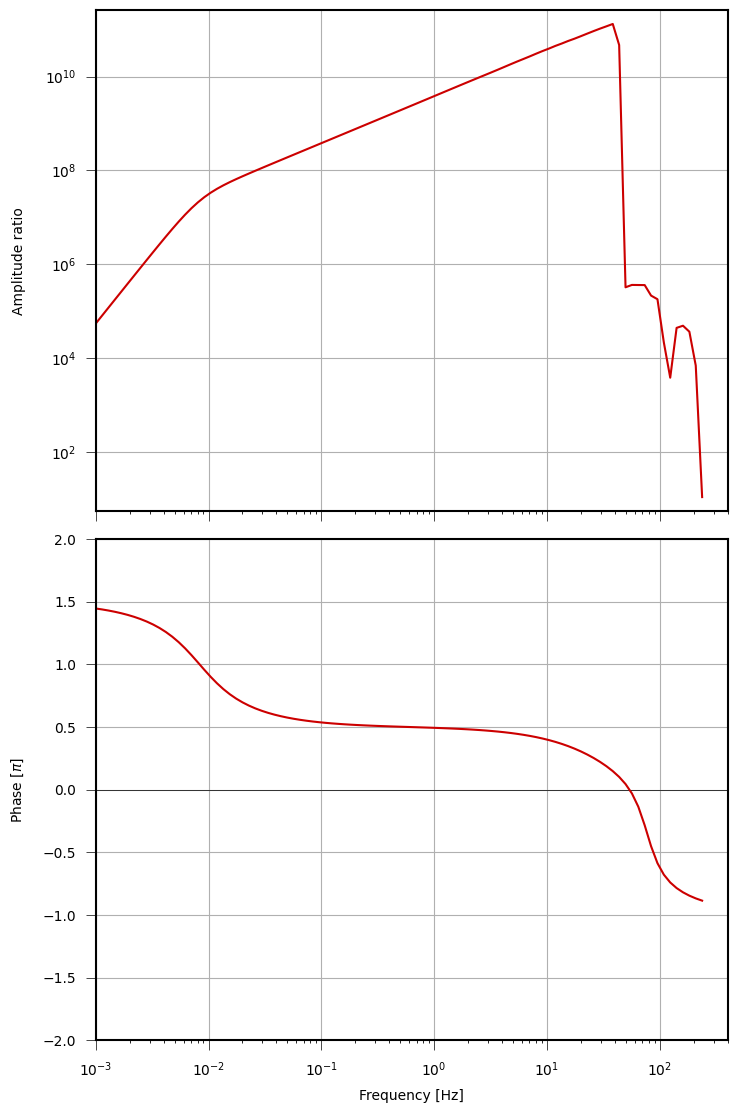

In [29]:
# Import pyrocko response plotting routine
from pyrocko.plot import response as response_plot

# Plotting the frequency depending response
response_plot.plot(
    responses=[response],
    fmin=0.001,
    fmax=400.,
    dpi=75.);

So, as there is a instrumental response for our chosen trace we can now use it to obtain the ground displacements during the recorded earthquake for the trace:

In [37]:
tr_rest = tr.transfer(
    0.,  # Rise time of the taper
    transfer_function=response,
    freqlimits=(0.001, 0.01, 10., 20.),
    invert=True,
    demean=True)

Comparing to the old raw trace shows the differences:

In [38]:
# Assing location code to distinguish waveforms in snuffler plot
tr_rest.set_location('DI')

# Plot the ground displacement
snuffle([tr_rest, tr]);

cc.py:pyrocko.gui.snuffling.okada - WARNING  - 
 /home/malde/.snufflings/okada/libokada.so: undefined symbol: okada_get_consts
--> run 'make' in okada snuffling directory <--


## Summary <a class="anchor" id="sum"></a>

Here we have covered simple techniques to 
* **load** StationXML into Pyrocko,
* convert StationXML to Pyrocko Stations with **get_pyrocko_stations**
* visualization techniques of station locations and responses,
* simple manipulation steps to add a new station (**Station** and **Channel**),
* writing of stations into a StationXML or Pyrocko YAML file,
* removal of the instrumental response from raw waveforms.